In [69]:
# Sinan Yumurtaci
# Code along for Chapter 4 of fast.ai's Practical Deep Learning for Coders

# Digit classification task
# Distinguish between images of digits
# Data source: MNIST

# also: 1st part of deep-dive to optimization using toy example of a parabolic function

# 2021-03-22

In [70]:
from fastbook import *
setup_book()
from fastai.vision.widgets import *

matplotlib.rc("image", cmap = "Greys")

In [71]:
# load the MNIST dataset

# book loads only 3 and 7 for demonstration.

# I'll be working on the classification for 2s and 4s
# so that I learn new stuff!
path = untar_data(URLs.MNIST)

In [72]:
path.ls()

# we see that the data is automatically divided into train and valid for us.
# there is also a labels.csv for us.

(#2) [Path('/Users/sinany/.fastai/data/mnist_png/training'),Path('/Users/sinany/.fastai/data/mnist_png/testing')]

In [73]:
(path/'training').ls()

# we see there is a folder for each digit.

(#10) [Path('/Users/sinany/.fastai/data/mnist_png/training/9'),Path('/Users/sinany/.fastai/data/mnist_png/training/0'),Path('/Users/sinany/.fastai/data/mnist_png/training/7'),Path('/Users/sinany/.fastai/data/mnist_png/training/6'),Path('/Users/sinany/.fastai/data/mnist_png/training/1'),Path('/Users/sinany/.fastai/data/mnist_png/training/8'),Path('/Users/sinany/.fastai/data/mnist_png/training/4'),Path('/Users/sinany/.fastai/data/mnist_png/training/3'),Path('/Users/sinany/.fastai/data/mnist_png/training/2'),Path('/Users/sinany/.fastai/data/mnist_png/training/5')]

In [74]:
# grab the filenames for the digits we are interested in (2 and 4)
# print our sample size

twos = (path/"training"/"2").ls().sorted()
fours = (path/"training"/"4").ls().sorted()
print(f"There are {len(twos)} 2s and {len(fours)} 4s.")

There are 5958 2s and 5842 4s.


In [75]:
# observe one of the 4s
img4_path = fours[0]
img4 = Image.open(img4_path)
img4

In [76]:
# look at the underlying data structure by observing a subset of the matrix that makes up the image.
array(img4)[10:20,10:20]

# this is the 'neck'

array([[  0,   0,   0,   0,   0,   0,   0,   0, 181, 252],
       [  0,   0,   0,   0,   0,   0,   0,  53, 232, 252],
       [  0,   0,   0,   0,   0,   0,   0,  73, 252, 252],
       [  0,   0,   0,   0,   0,   0,   0, 218, 253, 253],
       [ 73,  73,  42,   0,   0,   0,  94, 247, 252, 252],
       [252, 252, 222, 181, 181, 181, 212, 252, 252, 231],
       [252, 252, 253, 252, 252, 252, 253, 252, 252, 108],
       [253, 191, 145, 144, 160, 253, 255, 253, 154,   0],
       [ 35,  15,   0,   0,  37, 252, 253, 252,  71,   0],
       [  0,   0,   0,   0,  37, 252, 253, 200,  20,   0]], dtype=uint8)

In [77]:
# use pandas to draw the entire digit with the underlying values

img4_tensor = tensor(img4)
df = pd.DataFrame(img4_tensor)
df.style.set_properties(**{'font-size':'8pt'}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,109,47,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,207,252,148,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,212,252,252,252,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,84,253,252,252,168,0,0,0,0
9,0,0,0,0,0,0,0,63,62,0,0,0,0,0,0,0,0,0,99,252,253,252,153,0,0,0,0,0


# Baseline Model: Similarity to the Mean

Our baseline model will be a simple, non-learning model. It will quantify the distance to the mean image per digit, and label it based on closeness.

In [78]:
# load the actual images into tensors
two_tensors = [tensor(Image.open(f)) for f in twos]
four_tensors = [tensor(Image.open(f)) for f in fours]

print(f"Loaded {len(two_tensors)} 2s and {len(four_tensors)} 4s!")

Loaded 5958 2s and 5842 4s!


In [79]:
# stack the images for faster computation with PyTorch
# also convert from [0, 255] to [0, 1]
stacked_twos = torch.stack(two_tensors).float()/255
stacked_fours = torch.stack(four_tensors).float()/255\

# always nice to print sizes
print("Shaped of stacked 2 tensors:", stacked_twos.shape)

Shaped of stacked 2 tensors: torch.Size([5958, 28, 28])


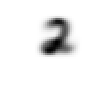

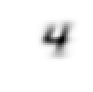

In [80]:
# calculate the 'mean' digit
mean_2 = stacked_twos.mean(0)
mean_4 = stacked_fours.mean(0)

show_image(mean_2)
show_image(mean_4)

# that is a blurry 2 and 4, which is to be expected with taking a mean

Here, we need to find the "distance" of a digit to the mean 2 and 4. If we were to just subtract, the positives and negatives might cancel out, so will want to apply a function that will make all distances positive. This is either abs(), or square. First, let's visualize what a difference might look like.

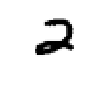

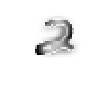

In [81]:
example_digit = stacked_twos[42]
show_image(example_digit) # this is the image we chose
show_image((example_digit - mean_2).abs()) # this is the residual image, with absolute.

In [82]:
# calculate distances of this image to 2 and 4, using both methods

dist_to2_absolute = (example_digit - mean_2).abs().mean()
dist_to2_square = ((example_digit - mean_2)**2).mean().sqrt() # we take sqrt at the end to normalize

dist_to4_absolute = (example_digit - mean_4).abs().mean()
dist_to4_square = ((example_digit - mean_4)**2).mean().sqrt() # we take sqrt at the end to normalize

print(f"Using absolute: dist to 2 is {dist_to2_absolute}, dist to 4 is {dist_to4_absolute}")
print(f"Using RMSE: dist to 2 is {dist_to2_square}, dist to 4 is {dist_to4_square}")

Using absolute: dist to 2 is 0.15597793459892273, dist to 4 is 0.21051399409770966
Using RMSE: dist to 2 is 0.2722765803337097, dist to 4 is 0.3633277714252472


In both cases, we see that this image is indeed closer to 2! We have succesfully prototyped a baseline model that does not even require a model!

Now, we should test our model accuracy by testing it on the testing set. Recall that we only "trained" using the data under training.

In [83]:
# load validation data
valid_2s = torch.stack([tensor(Image.open(f)) for f in (path/"testing"/"2").ls()]).float()/255
valid_4s = torch.stack([tensor(Image.open(f)) for f in (path/"testing"/"4").ls()]).float()/255

In [84]:
# define a function for calculating distance
# i will use the absolute definition for simplicity
def distance(a, b):
    return (a-b).abs().mean((-1,-2)) # defining the axis allows us to broadcast later
distance(example_digit, mean_2)

tensor(0.1560)

In [85]:
# write a function that will predict the label of an image tensor (or multiple images stacked)
# as True if it is 2, False otherwise (i.e. it is 4)
def is_2(x):
    return distance(x, mean_2) < distance(x, mean_4)

In [86]:
# calculate our models predictions on our testing set, calculate accuracy

accuracy_2 = is_2(valid_2s).float().mean()
accuracy_4 = (1 - is_2(valid_4s).float()).mean()

print(f"Our accuracy for 2s is {accuracy_2} and for 4s it is {accuracy_4}")

Our accuracy for 2s is 0.8808139562606812 and for 4s it is 1.0


Our model is seemingly perfect for identifying 4s, however, the accuracy for 2s is just 88%. This is a good baseline. A machine learning model will likely present a trade-off between these two, but I expect that we can build a model that is overall better!

# Digging Deep on Machine "Learning"
How does a machine learn? In the case of our machine learning models, it will be learning the best parameters to use at every step along the way. This learning is done by calculating the "gradient" (direction of greatest change) of a function that represents how good the current model is, and then taking a small step to that direction.

To demonstrate this, I will build a very simple model that will try to predict f(x) = x ** 3 with some noise added in. Then, I will demonstrate learning by plotting individual steps along the way.

In [123]:
# time steps:x
xtime = torch.arange(0,30).float();

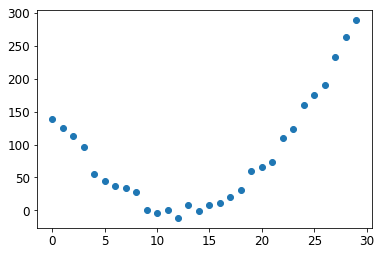

In [140]:
# y-values
values = torch.randn(30)*10 + (xtime - 12)**2
plt.scatter(xtime, values)

In [141]:
def f(t, params): # our model; generates a prediction when given an input (t) and its parameters
    a, b, c = params
    return a * (t**2) + b*t + c

In [142]:
# our loss function, root mean squared error
def rmse(preds, targets):
    return ((preds-targets)**2).mean().sqrt()

In [143]:
# initialize our parameters to random values
params = torch.randn(3).requires_grad_()
preds = f(xtime, params) # our predictions

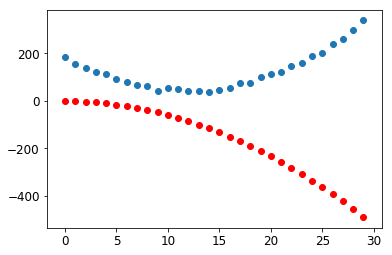

In [164]:
def plot_preds(preds, ax = None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(xtime, value)
    ax.scatter(xtime, to_np(preds), color='red')
plot_preds(preds)

In [177]:
# calculate loss
loss = rmse(preds, values)
loss # let's improve this!

tensor(56.6931, grad_fn=<SqrtBackward>)

In [178]:
# back-prop!
loss.backward()
params.grad

tensor([-0.0408,  1.4024, -0.1419])

In [185]:
learning_rate = 1e-3
params.grad * learning_rate

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [186]:
params.data -= params.grad.data * learning_rate
params.grad = None

AttributeError: 'NoneType' object has no attribute 'data'

In [187]:
preds = f(xtime, params)
rmse(preds, values) # it has likely decreased. our goal is to keep pushing this down!

tensor(838.8212, grad_fn=<SqrtBackward>)

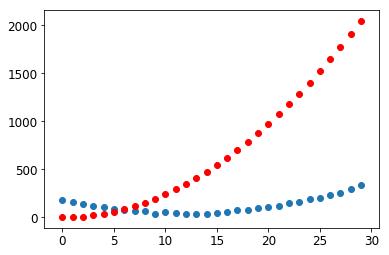

In [188]:
plot_preds(preds)

In [196]:
# package all the function calls to one "step" function
def take_step(params, verbose = True):
    preds = f(xtime, params)
    loss = rmse(preds, values)
    loss.backward()
    params.data -= params.grad.data * learning_rate
    params.grad = None
    if verbose:
        print(loss.item())
    return preds

In [197]:
for i in range(25):
    take_step(params)

74.5326919555664
344.781494140625
201.16763305664062
75.45731353759766
74.65097045898438
74.55006408691406
74.5352783203125
74.53306579589844
74.5327377319336
74.5326919555664
74.53268432617188
74.53267669677734
74.53268432617188
74.53269958496094
74.53267669677734
74.5326919555664
74.53268432617188
74.53269958496094
74.5326919555664
74.5326919555664
74.53269958496094
74.5326919555664
74.53268432617188
74.53268432617188
74.5326919555664


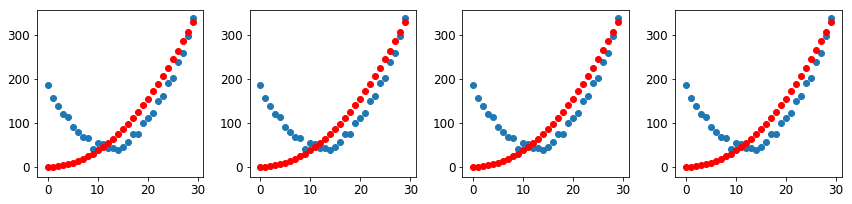

In [198]:
# our loss is going down, but wha tis happening underneath?
_, axs = plt.subplots(1,4, figsize = (12,3))
for ax in axs:
    plot_preds(take_step(params, False), ax)
    for i in range(5):
        take_step(params, False)
plt.tight_layout()

# Learning From Mistakes
Here, it seems I've hit a local minimum with my loss function! This means that my model will not improve further, because the gradient is at the "bottom of a valley", and there is nothing pushing the model outside of it. That is OK, since these are code-alongs are meant to be for perfectly copying, but about getting my hands dirty, and pushing the boundaries of my knowledge. I just stumbled upon a local minima, and it is a great learning experience!